In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import entr
from drift_ml.datasets.bosch_cnc_machining.utils.utils import augment_xyz_samples
from drift_ml.datasets.bosch_cnc_machining.utils.dataloader import RawBoschCNCDataloader, STFTBoschCNCDataloader, NPYBoschCNCDataLoader
import logging 
logging.getLogger('matplotlib').disabled = True

In [3]:
base_loader = NPYBoschCNCDataLoader(metadata_path="/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/metadata_ws4096.pkl")
base_loader.load_data(
    sample_data_x_path="/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/npy/sample_data_x_raw_ws4096.npy",
    sample_data_y_path="/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/npy/sample_data_y_raw_ws4096.npy"
    )
base_loader.generate_datasets_by_size(train_size=.4,val_size=.2,test_size=.4)

In [4]:
stft_base_loader = base_loader.get_windowed_samples_as_stft_dataloader(transform_fn=lambda x: x)
X_train_base, X_val_base, X_test_base = stft_base_loader.get_standardized_train_val_test()

  0%|          | 0/42978 [00:00<?, ?it/s]

In [5]:
from torch import tensor
from drift_ml.datasets.bosch_cnc_machining.utils.evaluation import Metrics
from drift_ml.datasets.bosch_cnc_machining.models.nnclassifier import NNClassifier

metric_calculator = Metrics()
model = NNClassifier()

In [6]:
model.fit(
    X_train_base, 
    stft_base_loader.y_train[:, np.newaxis], 
    X_val_base, 
    stft_base_loader.y_val[:, np.newaxis],
    lrate = 1e-2,
    epochs = 20,
    return_self=False
)

/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/models/nnclassifier.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor(X).to(self.device).float(),
DEBUG:root:Final val. performance: AUROC 0.92, AURPC 0.75, F1 0.77


In [7]:
y_base, y_base_scores = model.predict(X_test_base, return_scores=True)

base_entropies = entr(y_base_scores)
metric_calculator.print(y_base_scores, stft_base_loader.y_test[:, np.newaxis])

   BinaryAUROC  BinaryAveragePrecision  BinaryF1Score  BinaryMatthewsCorrCoef
0     0.879994                0.765618       0.822882                0.831058


In [8]:
shift = 40

print(f"Evaluating {shift} degrees pitch shift")
stft_loader = base_loader.get_windowed_samples_as_stft_dataloader(
    transform_fn=lambda x: augment_xyz_samples(x, pitch_deg=shift, yaw_deg=shift)
)
X_test_shift = stft_base_loader.standardize_datasets([stft_loader.X_test])[0]

Evaluating 40 degrees pitch shift


  0%|          | 0/42978 [00:00<?, ?it/s]

In [9]:
y_shift, y_shift_scores = model.predict(X_test_shift, return_scores=True)

shift_entropies = entr(y_shift_scores)
avg_entropy = np.mean(shift_entropies)

metric_calculator.print(y_shift_scores, stft_loader.y_test[:, np.newaxis])

   BinaryAUROC  BinaryAveragePrecision  BinaryF1Score  BinaryMatthewsCorrCoef
0     0.915663                0.774543       0.494005                0.509649


DEBUG:matplotlib.ticker:vmin 0.05042557353276605 vmax 1368.8562590781191
DEBUG:matplotlib.ticker:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05])
DEBUG:matplotlib.ticker:vmin 0.05042557353276605 vmax 1368.8562590781191
DEBUG:matplotlib.ticker:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05])
DEBUG:matplotlib.ticker:vmin 0.05042557353276605 vmax 1368.8562590781191
DEBUG:matplotlib.ticker:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05])
DEBUG:matplotlib.ticker:vmin 0.05042557353276605 vmax 1368.8562590781191
DEBUG:matplotlib.ticker:ticklocs array([2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 

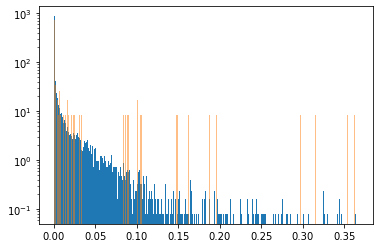

In [10]:
plt.hist(base_entropies[stft_base_loader.y_test[:, np.newaxis] == y_base], log=True, density=True, bins=500)
plt.hist(base_entropies[stft_base_loader.y_test[:, np.newaxis] != y_base], log=True, density=True, bins=500, alpha=0.5)
plt.show()

DEBUG:matplotlib.ticker:vmin 0.05239390403572408 vmax 1218.4096660384464
DEBUG:matplotlib.ticker:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05])
DEBUG:matplotlib.ticker:vmin 0.05239390403572408 vmax 1218.4096660384464
DEBUG:matplotlib.ticker:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05])
DEBUG:matplotlib.ticker:vmin 0.05239390403572408 vmax 1218.4096660384464
DEBUG:matplotlib.ticker:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05])
DEBUG:matplotlib.ticker:vmin 0.05239390403572408 vmax 1218.4096660384464
DEBUG:matplotlib.ticker:ticklocs array([2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 

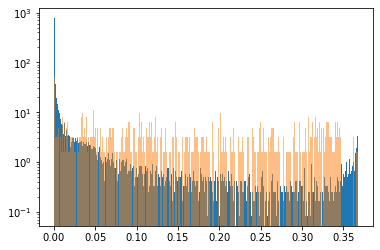

In [11]:
plt.hist(shift_entropies[stft_loader.y_test[:, np.newaxis] == y_shift], log=True, density=True, bins=500)
plt.hist(shift_entropies[stft_loader.y_test[:, np.newaxis] != y_shift], log=True, density=True, bins=500, alpha=0.5)
plt.show()

DEBUG:matplotlib.ticker:vmin 0.009832835096081407 vmax 328.98222367109634
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])
DEBUG:matplotlib.ticker:vmin 0.009832835096081407 vmax 328.98222367109634
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])
DEBUG:matplotlib.ticker:vmin 0.009832835096081407 vmax 328.98222367109634
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])
DEBUG:matplotlib.ticker:vmin 0.009832835096081407 vmax 328.98222367109634
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+

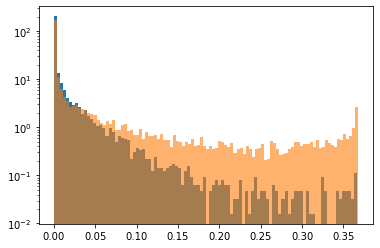

In [12]:
plt.hist(base_entropies, log=True, density=True, bins=100)
plt.hist(shift_entropies, log=True, density=True, bins=100, alpha=0.6)
plt.show()

In [13]:
import seaborn as sns